In [12]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import AdaptiveGamificationAgent
import matplotlib.pyplot as plt

In [13]:
elems=list(corr_gamification_elements.values())
elems2=list(sample_gamification_elements.values())
hexad=hexad_load_dict(pl=2,ach=4,ph=2,dis=4,s=1,fs=0.5).load_dict
mods={"pl":0.5,"Badges":100}
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=elems2,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(1000,500))
obs,_=env.reset()

In [14]:
agent=AdaptiveGamificationAgent(0.1,0.01,0.95,env)

In [15]:
obs,_=env.reset()
for _ in range(200000):
    action=agent.random_action(env)
    new_obs,reward,_,_,info=env.step(action)
    agent.update(obs,action,reward,new_obs)
    obs=new_obs
    action,reward,obs,info



In [16]:
r=[]
b=[]
actions=defaultdict(lambda:{'x':[],'y':[]})
ans=['accept','decline']
obs,_=env.reset()
for i in range(1000):
    action=agent.get_action(obs)
    env.set_user_answer(ans[random.randint(0,1)])
    new_obs,reward,_,_,info=env.step(action)
    b.append((action,reward))
    r.append(reward)
    actions[action]['x'].append(i)
    actions[action]['y'].append(reward)
    agent.update(obs,action,reward,new_obs)
    obs=new_obs
    old_state=obs
    for _ in range(2000):
        action=agent.random_action(env)
        new_obs,reward,_,_,info=env.step(action)
        agent.update(obs,action,reward,new_obs)
        obs=new_obs
        action,reward,obs,info
    env.set_history(old_state)
    obs=old_state

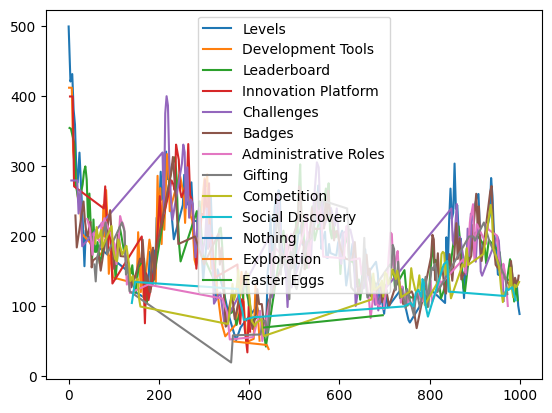

In [17]:
for i in actions:
    plt.plot(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i])
    ax=plt.gca()
    ax.legend()


2 Badges pl
3 Leaderboard pl
4 Levels ach
5 Challenges ach
6 Exploration fs
1 Easter Eggs fs
2 Innovation Platform dis
3 Development Tools dis
4 Administrative Roles ph
5 Gifting ph
6 Social Discovery s
1 Competition s
2 Nothing None


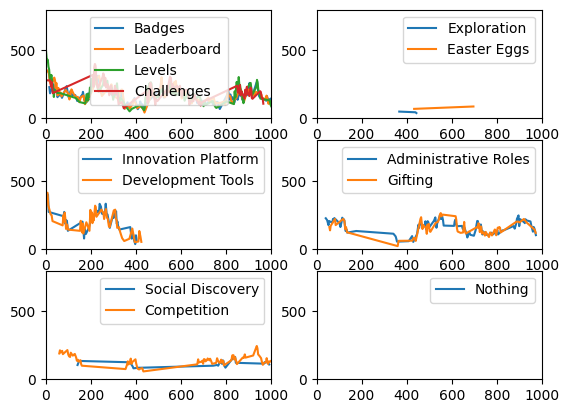

In [28]:
typ='pl'
j=1
plt.subplot(3,2,j)
for i,_ in sorted(actions.items()):
    
    name=env.action_to_ge[i]
    plt.subplot(3,2,hexad_types.index(env.ge[name].type))
    plt.ylim(0,800)
    plt.xlim(0,1000)
    plt.plot(actions[i]['x'],actions[i]['y'],label=name)
    ax=plt.gca()
    ax.legend()

In [21]:
actions[13]

{'x': [349], 'y': [37.500032000000125]}

In [19]:
hex_base=[0,1,2,3,4,5]
comb=permutations(hex_base)
r1=[]
a=[]
j=0
for hex_v in comb:
    hexad=hexad_load_dict.from_list(hex_v).load_dict
    env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',gamification_elements=elems,hexad_load=hexad)
    env.reset()
    r1.append([])
    for i in range(1,14):
        _,reward,_,_,_=env.step(action=i)
        r1[j].append(reward)
        _,reward,_,_,_=env.step(action=i)
        r1[j].append(reward)
        _,reward,_,_,_=env.step(action=i)
        r1[j].append(reward)
    a.append(sum(r1[j])/len(r1[j]))
    j+=1
r2=[]
c=[]
j=0
comb=permutations(hex_base)
for hex_v in comb:
    hexad=hexad_load_dict.from_list(hex_v).load_dict
    env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',gamification_elements=elems2,hexad_load=hexad)
    env.reset()
    r2.append([])
    for i in range(1,14):
        _,reward,_,_,_=env.step(action=i)
        r2[j].append(reward)
        _,reward,_,_,_=env.step(action=i)
        r2[j].append(reward)
        _,reward,_,_,_=env.step(action=i)
        r2[j].append(reward)
    c.append(sum(r2[j])/len(r2[j]))
    j+=1

In [20]:
diff=[]
for i in range(len(c)):
    diff.append((b[i]-c[i]))
print(sum(diff)/len(diff))

TypeError: unsupported operand type(s) for -: 'tuple' and 'float'